In [36]:
!pip install autogluon

In [37]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/X11: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/X11/encodings: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/X11/encodings/large: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/X11/misc: caching, new cache contents: 89 fonts, 0 dirs
/usr/share/fonts/X11/util: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 22 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/share/fonts/type1: caching, n

In [38]:
# from google.colab import drive
# drive.mount('/content/drive')

In [39]:
import pandas as pd
import numpy as np
import os
import random
from tqdm.auto import tqdm
# import optuna

DATA_PATH = '/kaggle/input/jeju-dataset'
# DATA_PATH = '/content/drive/MyDrive/데이터 분석/데이콘 캐글 컴페티션/예슬 개인 참가/제주 특산물 가격 예측/data/'

SEED = 42

In [40]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED) # Seed 고정

In [41]:
import numpy as snp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings(action='ignore')

In [42]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn import tree
# from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.model_selection import KFold, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, make_scorer

```
item : 품목 코드
TG : 감귤
BC : 브로콜리
RD : 무
CR : 당근
CB : 양배추
corporation : 유통 법인 코드
법인 A부터 F 존재
location : 지역 코드
J : 제주도 제주시
S : 제주도 서귀포시
supply(kg) : 유통된 물량, kg 단위
price(원/kg) : 유통된 품목들의 kg 마다의 가격, 원 단위
```

# DATA Load

In [105]:
DATA_PATH = '/kaggle/input/jeju-dataset/'

train_df = pd.read_csv(f"{DATA_PATH}train.csv")
test_df = pd.read_csv(f"{DATA_PATH}test.csv")
international = pd.read_csv(f"{DATA_PATH}international_trade.csv")
submission = pd.read_csv(f"{DATA_PATH}sample_submission.csv")

In [106]:
train_df.head()

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0


In [107]:
train_df.rename(columns={'supply(kg)':'supply', 'price(원/kg)':'price'}, inplace=True)
train_df

,ID,timestamp,item,corporation,location,supply,price
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0
...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0


In [108]:
test_df

,ID,timestamp,item,corporation,location
0,TG_A_J_20230304,2023-03-04,TG,A,J
1,TG_A_J_20230305,2023-03-05,TG,A,J
2,TG_A_J_20230306,2023-03-06,TG,A,J
3,TG_A_J_20230307,2023-03-07,TG,A,J
4,TG_A_J_20230308,2023-03-08,TG,A,J
...,...,...,...,...,...
1087,RD_F_J_20230327,2023-03-27,RD,F,J
1088,RD_F_J_20230328,2023-03-28,RD,F,J
1089,RD_F_J_20230329,2023-03-29,RD,F,J
1090,RD_F_J_20230330,2023-03-30,RD,F,J


In [109]:
international.head()

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
0,2019-01,토마토(신선한 것이나 냉장한 것으로 한정한다),356571,990,0,0,990
1,2019-01,양파,821330,222,4003206,1118,-896
2,2019-01,쪽파,60,1,93405,128,-127
3,2019-01,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562
4,2019-01,방울다다기 양배추,0,0,7580,38,-38


# Preprocessing

In [110]:
# 공휴일
holi_weekday = ['2019-01-01', '2019-02-04', '2019-02-05', '2019-02-06', '2019-03-01', '2019-05-05', '2019-05-12', '2019-06-06', '2019-08-15', '2019-09-12', '2019-09-13', '2019-09-14', '2019-10-03', '2019-10-09', '2019-12-25',
                '2020-01-01' ,'2020-01-24' ,'2020-01-25', '2020-01-26', '2020-03-01', '2020-04-30', '2020-05-05', '2020-06-06', '2020-08-15', '2020-08-17', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-09', '2020-12-25',
                '2021-01-01' ,'2021-02-11' ,'2021-02-12', '2021-02-13', '2021-03-01', '2021-05-05', '2021-05-19', '2021-06-06', '2021-08-15', '2021-09-20', '2021-09-21', '2021-09-22', '2021-10-03', '2021-10-09', '2021-12-25',
                '2022-01-01' ,'2022-01-31' ,'2022-02-01', '2022-02-02', '2022-03-01', '2022-05-05', '2022-05-08', '2022-06-06', '2022-08-15', '2022-09-09', '2022-09-10', '2022-09-11', '2022-09-12', '2022-10-03', '2022-10-09', '2020-10-10', '2022-12-25',
                '2023-01-01' ,'2023-01-21' ,'2023-01-22', '2023-01-23', '2023-01-24', '2023-03-01']

In [111]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
train_df['year'] = train_df['timestamp'].dt.year
train_df['month'] = train_df['timestamp'].dt.month
train_df['week'] = train_df['timestamp'].dt.isocalendar().week
train_df['day'] = train_df['timestamp'].dt.day
train_df['day_of_week'] = train_df['timestamp'].dt.dayofweek
# train_df['sin_week'] = np.sin(2 * np.pi * train_df['week'] / 4)
# train_df['cos_week'] = np.cos(2 * np.pi * train_df['week'] / 4)
# train_df['sin_dayofweek'] = np.sin(2 * np.pi * (train_df['day_of_week'] + 1) / 7)
# train_df['cos_dayofweek'] = np.cos(2 * np.pi * (train_df['day_of_week'] + 1) / 7)
train_df['holiday'] = np.where((train_df.day_of_week >= 5) | (train_df.timestamp.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0)

test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
test_df['year'] = test_df['timestamp'].dt.year
test_df['month'] = test_df['timestamp'].dt.month
test_df['week'] = test_df['timestamp'].dt.isocalendar().week
test_df['day'] = test_df['timestamp'].dt.day
test_df['day_of_week'] = test_df['timestamp'].dt.dayofweek
# test_df['sin_week'] = np.sin(2 * np.pi * test_df['week'] / 4)
# test_df['cos_week'] = np.cos(2 * np.pi * test_df['week'] / 4)
# test_df['sin_dayofweek'] = np.sin(2 * np.pi * (test_df['day_of_week'] + 1) / 7)
# test_df['cos_dayofweek'] = np.cos(2 * np.pi * (test_df['day_of_week'] + 1) / 7)
test_df['holiday'] = np.where((test_df.day_of_week >= 5) | (test_df.timestamp.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0)

In [112]:

import math

# 연중일 주기
def cos_year(date):
    day_of_year = date.timetuple().tm_yday  # 해당 날짜의 연중 몇 번째 날인지를 가져옵니다.
    period = 365  # 1년은 365일
    return math.cos(2 * math.pi * day_of_year / period)

def sin_year(date):
    day_of_year = date.timetuple().tm_yday  # 해당 날짜의 연중 몇 번째 날인지를 가져옵니다.
    period = 365  # 1년은 365일
    return math.sin(2 * math.pi * day_of_year / period)

train_df['cos_year'] = train_df['timestamp'].apply(cos_year)
train_df['sin_year'] = train_df['timestamp'].apply(sin_year)

test_df['cos_year'] = test_df['timestamp'].apply(cos_year)
test_df['sin_year'] = test_df['timestamp'].apply(sin_year)

# 요일 주기 (주간)
def cos_weekday(date):
    day_of_week = date.weekday()  # Monday is 0, Sunday is 6
    period = 7  # 1 week has 7 days
    return math.cos(2 * math.pi * day_of_week / period)

def sin_weekday(date):
    day_of_week = date.weekday()  # Monday is 0, Sunday is 6
    period = 7  # 1 week has 7 days
    return math.sin(2 * math.pi * day_of_week / period)

train_df['cos_dow'] = train_df['timestamp'].apply(cos_weekday)
train_df['sin_dow'] = train_df['timestamp'].apply(sin_weekday)

test_df['cos_dow'] = test_df['timestamp'].apply(cos_weekday)
test_df['sin_dow'] = test_df['timestamp'].apply(sin_weekday)

# 연중주 주기
def cos_week_of_year(date):
    week_of_year = date.isocalendar()[1]  # Get the ISO week number
    period = 52  # 1 year has 52 weeks
    return math.cos(2 * math.pi * week_of_year / period)

def sin_week_of_year(date):
    week_of_year = date.isocalendar()[1]  # Get the ISO week number
    period = 52  # 1 year has 52 weeks
    return math.sin(2 * math.pi * week_of_year / period)

train_df['cos_week_of_year'] = train_df['timestamp'].apply(cos_week_of_year)
train_df['sin_week_of_year'] = train_df['timestamp'].apply(sin_week_of_year)

test_df['cos_week_of_year'] = test_df['timestamp'].apply(cos_week_of_year)
test_df['sin_week_of_year'] = test_df['timestamp'].apply(sin_week_of_year)

## 월별 품목의 가격 추가(mean, max)

In [113]:
train_df['month_of_year'] = train_df['timestamp'].dt.to_period('M')
test_df['month_of_year'] = test_df['timestamp'].dt.to_period('M')

train_df.head()

,ID,timestamp,item,corporation,location,supply,price,year,month,week,day,day_of_week,holiday,cos_year,sin_year,cos_dow,sin_dow,cos_week_of_year,sin_week_of_year,month_of_year
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1,1,1,0.999852,0.017213,0.623490,0.781831,0.992709,0.120537,2019-01
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,1,2,2,0,0.999407,0.034422,-0.222521,0.974928,0.992709,0.120537,2019-01
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,1,3,3,0,0.998667,0.051620,-0.900969,0.433884,0.992709,0.120537,2019-01
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,1,4,4,0,0.997630,0.068802,-0.900969,-0.433884,0.992709,0.120537,2019-01
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,1,5,5,1,0.996298,0.085965,-0.222521,-0.974928,0.992709,0.120537,2019-01


In [114]:
item_month_price = train_df.groupby(['item', 'month_of_year'])
agg = {'price' : ['mean', 'max']}
price_df = item_month_price.agg(agg).reset_index()
price_df

item month_of_year        price        
                               mean     max
0     BC       2019-01  1278.086022  2689.0
1     BC       2019-02  1152.563492  2925.0
2     BC       2019-03  1772.620072  4149.0
3     BC       2019-04  2288.400000  6929.0
4     BC       2019-05   658.265233  5965.0
..   ...           ...          ...     ...
250   TG       2022-11  1361.850000  2526.0
251   TG       2022-12  1696.103226  4202.0
252   TG       2023-01  1782.693548  8000.0
253   TG       2023-02  2250.250000  8500.0
254   TG       2023-03  3442.633333  6382.0

[255 rows x 4 columns]

In [115]:
price_df.columns = ['item', 'month_of_year', 'month_price_mean', 'month_price_max']
train_df = pd.merge(train_df, price_df, on=['item', 'month_of_year'], how='left')
train_df.head()

,ID,timestamp,item,corporation,location,supply,price,year,month,week,...,holiday,cos_year,sin_year,cos_dow,sin_dow,cos_week_of_year,sin_week_of_year,month_of_year,month_price_mean,month_price_max
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,...,1,0.999852,0.017213,0.623490,0.781831,0.992709,0.120537,2019-01,1485.383871,4031.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,1,...,0,0.999407,0.034422,-0.222521,0.974928,0.992709,0.120537,2019-01,1485.383871,4031.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,1,...,0,0.998667,0.051620,-0.900969,0.433884,0.992709,0.120537,2019-01,1485.383871,4031.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,1,...,0,0.997630,0.068802,-0.900969,-0.433884,0.992709,0.120537,2019-01,1485.383871,4031.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,1,...,1,0.996298,0.085965,-0.222521,-0.974928,0.992709,0.120537,2019-01,1485.383871,4031.0


In [116]:
# 테스트셋 반영
test_df = pd.merge(test_df, price_df, on=['item', 'month_of_year'], how='left')
test_df.head()

,ID,timestamp,item,corporation,location,year,month,week,day,day_of_week,holiday,cos_year,sin_year,cos_dow,sin_dow,cos_week_of_year,sin_week_of_year,month_of_year,month_price_mean,month_price_max
0,TG_A_J_20230304,2023-03-04,TG,A,J,2023,3,9,4,5,1,0.467359,0.884068,-0.222521,-0.974928,0.464723,0.885456,2023-03,3442.633333,6382.0
1,TG_A_J_20230305,2023-03-05,TG,A,J,2023,3,9,5,6,1,0.452072,0.891981,0.623490,-0.781831,0.464723,0.885456,2023-03,3442.633333,6382.0
2,TG_A_J_20230306,2023-03-06,TG,A,J,2023,3,10,6,0,0,0.436651,0.899631,1.000000,0.000000,0.354605,0.935016,2023-03,3442.633333,6382.0
3,TG_A_J_20230307,2023-03-07,TG,A,J,2023,3,10,7,1,0,0.421101,0.907014,0.623490,0.781831,0.354605,0.935016,2023-03,3442.633333,6382.0
4,TG_A_J_20230308,2023-03-08,TG,A,J,2023,3,10,8,2,0,0.405426,0.914128,-0.222521,0.974928,0.354605,0.935016,2023-03,3442.633333,6382.0


## 월별 품목의 물량 추가(mean, max)

- 전달 물량 추가 / 3개월 물량 추가

In [117]:
item_month_supply = train_df.groupby(['item', 'month_of_year'])
agg = {'supply' : ['mean', 'max']}
supply_df = item_month_supply.agg(agg).reset_index()
supply_df

item month_of_year        supply          
                                mean       max
0     BC       2019-01   2494.161290   14584.0
1     BC       2019-02   2288.412698   15184.0
2     BC       2019-03   2056.946237   14048.0
3     BC       2019-04   1347.229630   10136.0
4     BC       2019-05    124.301075    3792.0
..   ...           ...           ...       ...
250   TG       2022-11  29303.189000  104781.0
251   TG       2022-12  34294.561290  129891.0
252   TG       2023-01  27517.410968  127048.0
253   TG       2023-02  19588.908571   78797.0
254   TG       2023-03  16526.743333   47819.0

[255 rows x 4 columns]

In [118]:
supply_df.columns = ['item', 'month_of_year', 'month_supply_mean', 'month_supply_max']
supply_df

,item,month_of_year,month_supply_mean,month_supply_max
0,BC,2019-01,2494.161290,14584.0
1,BC,2019-02,2288.412698,15184.0
2,BC,2019-03,2056.946237,14048.0
3,BC,2019-04,1347.229630,10136.0
4,BC,2019-05,124.301075,3792.0
...,...,...,...,...
250,TG,2022-11,29303.189000,104781.0
251,TG,2022-12,34294.561290,129891.0
252,TG,2023-01,27517.410968,127048.0
253,TG,2023-02,19588.908571,78797.0


In [119]:
supply_df.columns = ['item', 'month_of_year', 'month_supply_mean', 'month_supply_max']
train_df = pd.merge(train_df, supply_df, on=['item', 'month_of_year'], how='left')
train_df.head()

,ID,timestamp,item,corporation,location,supply,price,year,month,week,...,sin_year,cos_dow,sin_dow,cos_week_of_year,sin_week_of_year,month_of_year,month_price_mean,month_price_max,month_supply_mean,month_supply_max
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,...,0.017213,0.623490,0.781831,0.992709,0.120537,2019-01,1485.383871,4031.0,47433.957097,268073.4
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,1,...,0.034422,-0.222521,0.974928,0.992709,0.120537,2019-01,1485.383871,4031.0,47433.957097,268073.4
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,1,...,0.051620,-0.900969,0.433884,0.992709,0.120537,2019-01,1485.383871,4031.0,47433.957097,268073.4
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,1,...,0.068802,-0.900969,-0.433884,0.992709,0.120537,2019-01,1485.383871,4031.0,47433.957097,268073.4
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,1,...,0.085965,-0.222521,-0.974928,0.992709,0.120537,2019-01,1485.383871,4031.0,47433.957097,268073.4


In [120]:
# 테스트셋 반영
test_df = pd.merge(test_df, supply_df, on=['item', 'month_of_year'], how='left')
test_df.head()

,ID,timestamp,item,corporation,location,year,month,week,day,day_of_week,...,sin_year,cos_dow,sin_dow,cos_week_of_year,sin_week_of_year,month_of_year,month_price_mean,month_price_max,month_supply_mean,month_supply_max
0,TG_A_J_20230304,2023-03-04,TG,A,J,2023,3,9,4,5,...,0.884068,-0.222521,-0.974928,0.464723,0.885456,2023-03,3442.633333,6382.0,16526.743333,47819.0
1,TG_A_J_20230305,2023-03-05,TG,A,J,2023,3,9,5,6,...,0.891981,0.623490,-0.781831,0.464723,0.885456,2023-03,3442.633333,6382.0,16526.743333,47819.0
2,TG_A_J_20230306,2023-03-06,TG,A,J,2023,3,10,6,0,...,0.899631,1.000000,0.000000,0.354605,0.935016,2023-03,3442.633333,6382.0,16526.743333,47819.0
3,TG_A_J_20230307,2023-03-07,TG,A,J,2023,3,10,7,1,...,0.907014,0.623490,0.781831,0.354605,0.935016,2023-03,3442.633333,6382.0,16526.743333,47819.0
4,TG_A_J_20230308,2023-03-08,TG,A,J,2023,3,10,8,2,...,0.914128,-0.222521,0.974928,0.354605,0.935016,2023-03,3442.633333,6382.0,16526.743333,47819.0


In [121]:
# 공급과 가격의 상관관계
sup_price_corr = train_df['supply'].corr(train_df['price'])
sup_price_corr

-0.0022967366004861545

## 유닉스 타임스탬프
- 1970년 1월 1일부터의 초 단위 경과 시간으로 변환

In [122]:
# # timestamp
# train_df['timestamp'] = (train_df['timestamp'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
# test_df['timestamp'] = (test_df['timestamp'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')

# train_df['timestamp']

In [123]:
# # month
# train_df['month'] = (train_df['month'].dt.to_timestamp() - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
# test_df['month'] = (test_df['month'].dt.to_timestamp() - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')

# test_df['month']

## international 데이터 merge

In [124]:
international = international.rename(columns={
    '기간': 'period',
    '품목명': 'item',
    '수출 중량': 'exWeight',
    '수출 금액': 'exValue',
    '수입 중량': 'imWeight',
    '수입 금액': 'imValue',
    '무역수지': 'tradeBalance'
})

international.head()

,period,item,exWeight,exValue,imWeight,imValue,tradeBalance
0,2019-01,토마토(신선한 것이나 냉장한 것으로 한정한다),356571,990,0,0,990
1,2019-01,양파,821330,222,4003206,1118,-896
2,2019-01,쪽파,60,1,93405,128,-127
3,2019-01,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562
4,2019-01,방울다다기 양배추,0,0,7580,38,-38


In [125]:
len(international['item'].unique())

34

In [126]:
train_df.columns

Index(['ID', 'timestamp', 'item', 'corporation', 'location', 'supply', 'price',
       'year', 'month', 'week', 'day', 'day_of_week', 'holiday', 'cos_year',
       'sin_year', 'cos_dow', 'sin_dow', 'cos_week_of_year',
       'sin_week_of_year', 'month_of_year', 'month_price_mean',
       'month_price_max', 'month_supply_mean', 'month_supply_max'],
      dtype='object')

In [127]:
international['item'].value_counts()

감귤                                                                               50
포포(papaw)[파파야(papaya)]                                                           50
레몬[시트러스 리몬(Citrus limon)ㆍ시트러스 리머늄(Citrus limonum)]                               50
그레이프프루트(grapefruit)와 포멜로(pomelo)                                                 50
오렌지                                                                              50
망고(mango)                                                                        50
파인애플                                                                             50
무화과                                                                              50
대추야자                                                                             50
사과                                                                               50
오이류(신선한 것이나 냉장한 것으로 한정한다)                                                        50
당근                                                                          

In [128]:
trade_df = international.groupby(['item','period'])[['exWeight','exValue','imWeight','imValue','tradeBalance']].sum().reset_index()
trade_df

,item,period,exWeight,exValue,imWeight,imValue,tradeBalance
0,감귤,2019-01,58368,172,0,0,172
1,감귤,2019-02,8474,33,0,0,33
2,감귤,2019-03,2061,10,4599,12,-2
3,감귤,2019-04,328,9,13457,36,-27
4,감귤,2019-05,2560,21,0,0,21
...,...,...,...,...,...,...,...
1269,포포(papaw)[파파야(papaya)],2022-10,0,0,19840,56,-56
1270,포포(papaw)[파파야(papaya)],2022-11,0,0,13600,40,-40
1271,포포(papaw)[파파야(papaya)],2022-12,0,0,15040,48,-48
1272,포포(papaw)[파파야(papaya)],2023-01,0,0,10590,34,-34


In [67]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/X11: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/X11/encodings: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/X11/encodings/large: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/X11/misc: caching, new cache contents: 89 fonts, 0 dirs
/usr/share/fonts/X11/util: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 22 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/share/fonts/type1: caching, n

In [68]:
from matplotlib import rc

rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

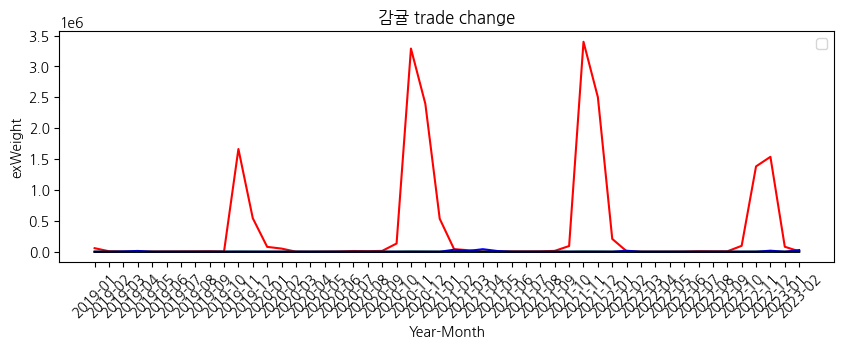

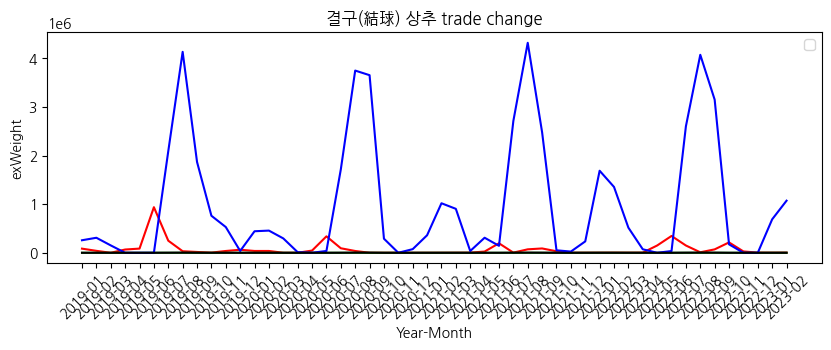

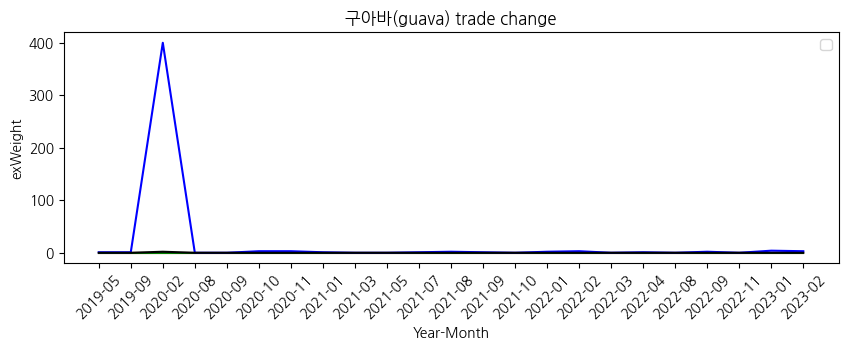

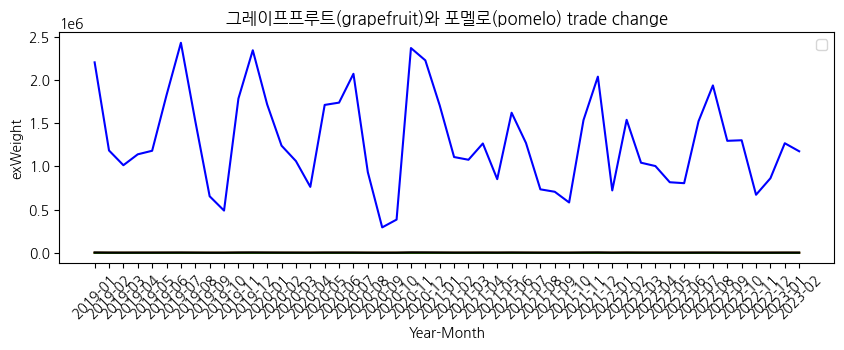

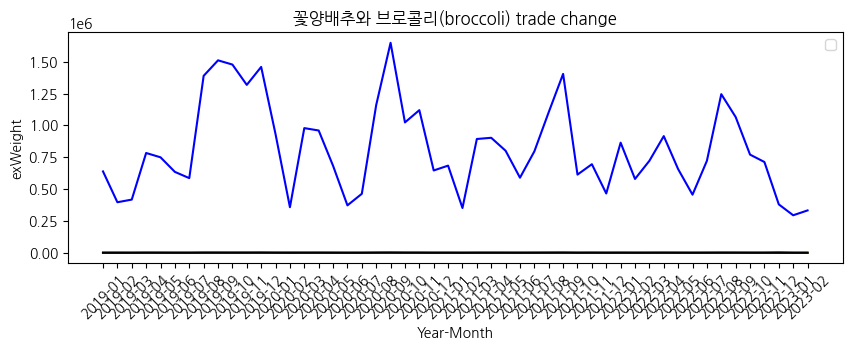

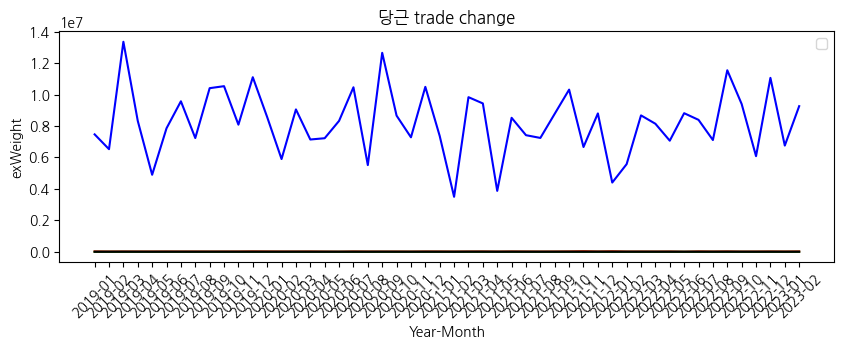

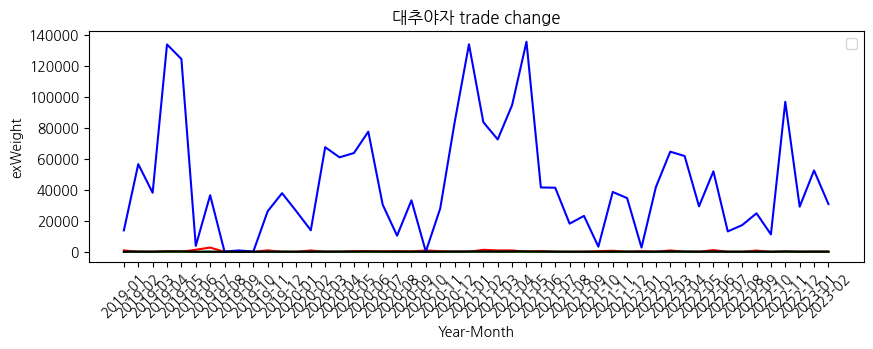

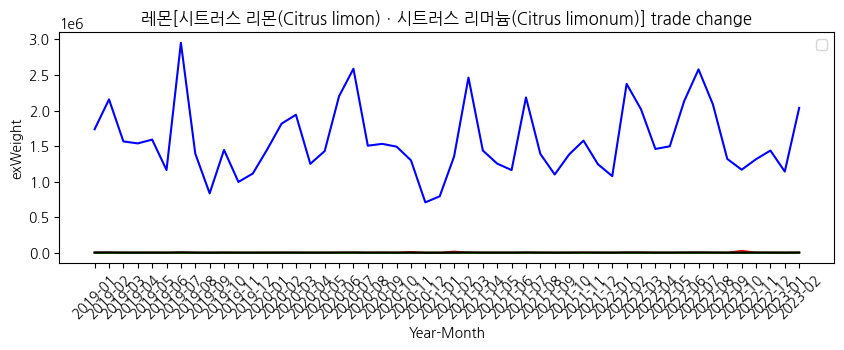

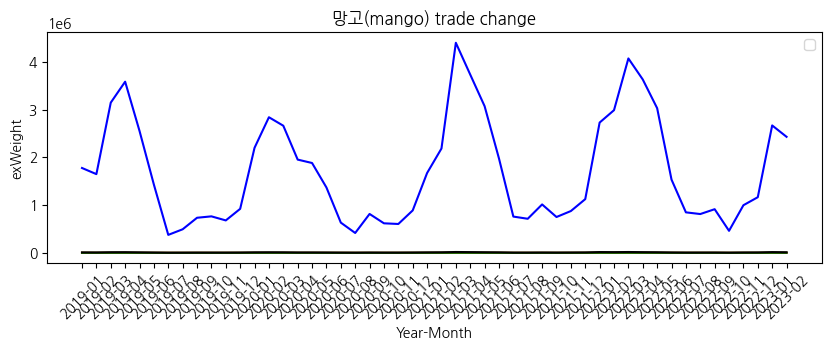

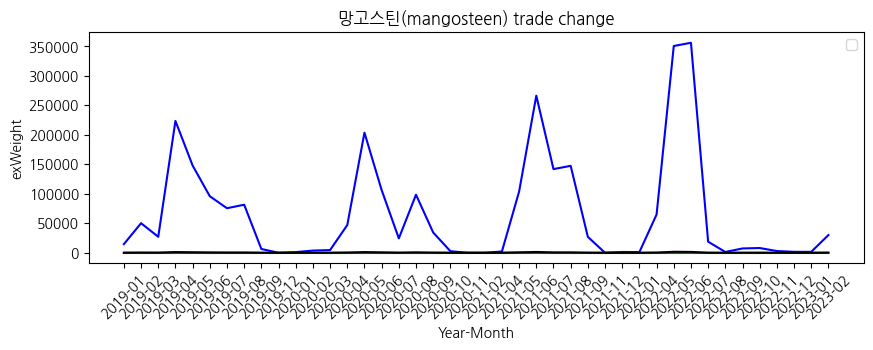

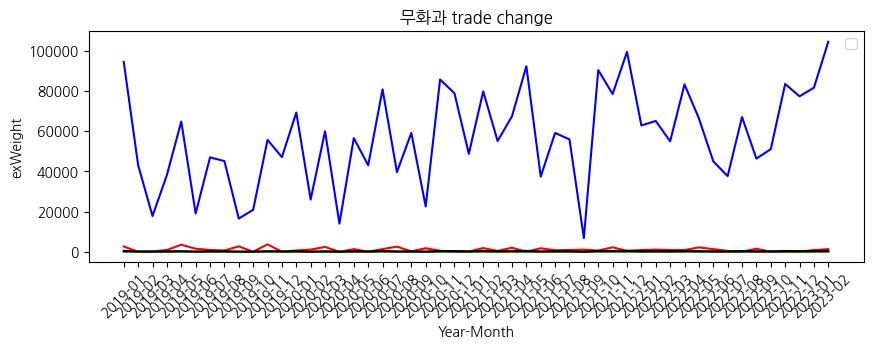

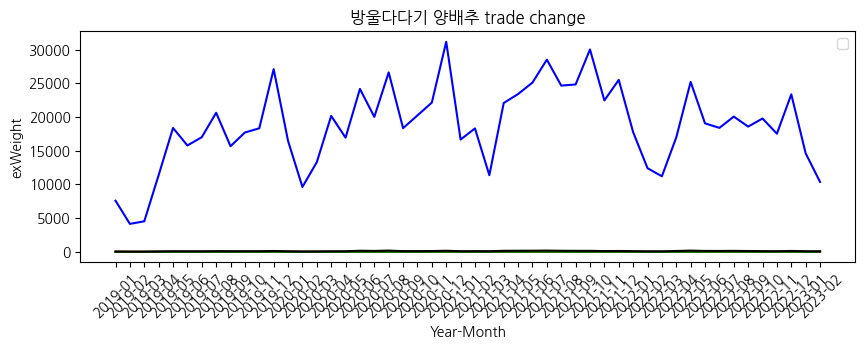

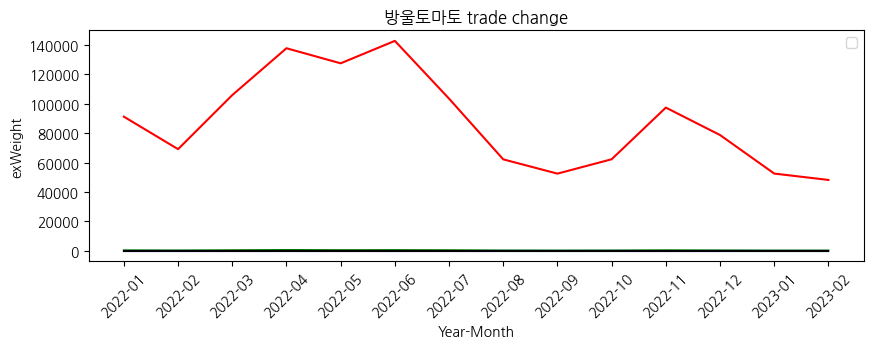

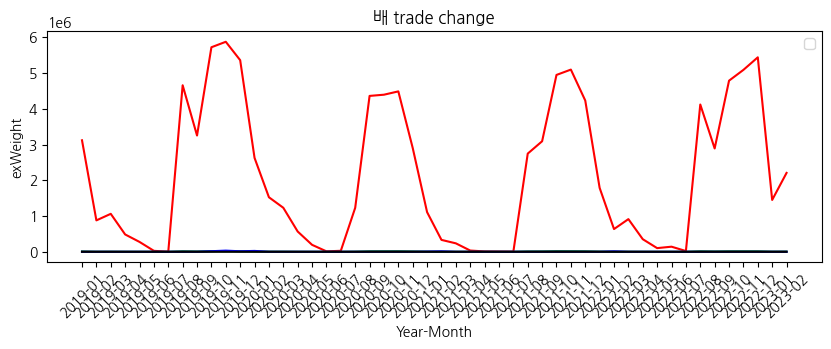

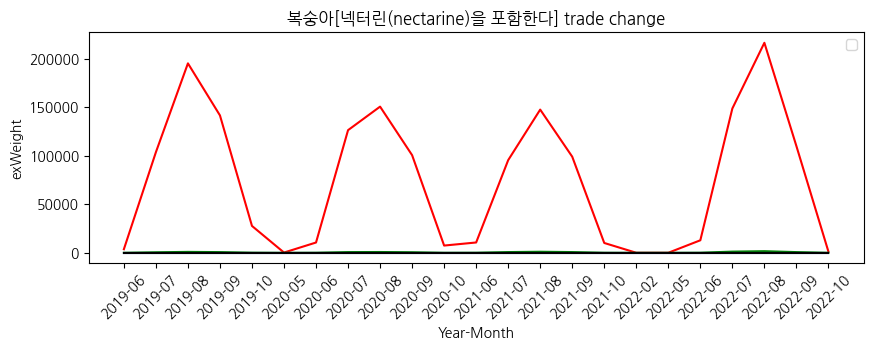

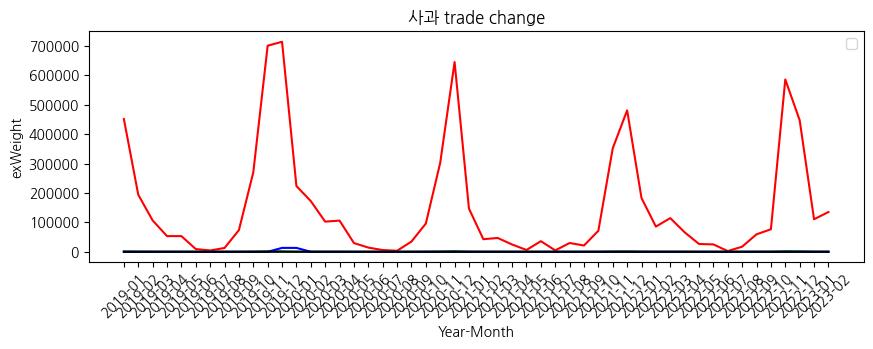

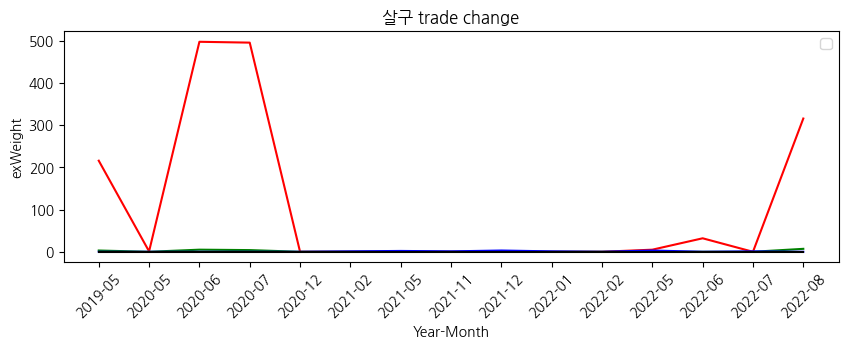

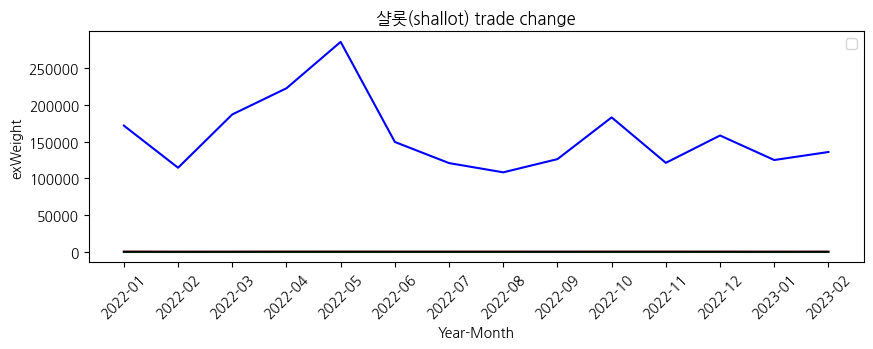

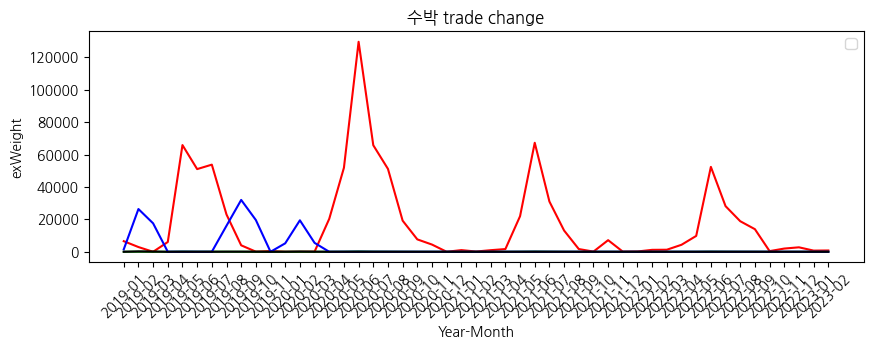

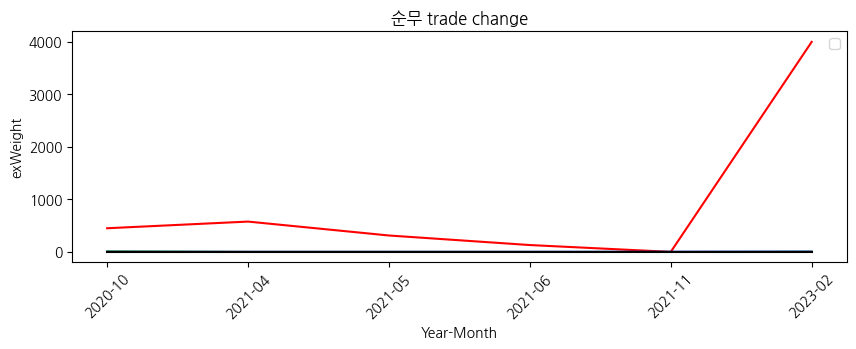

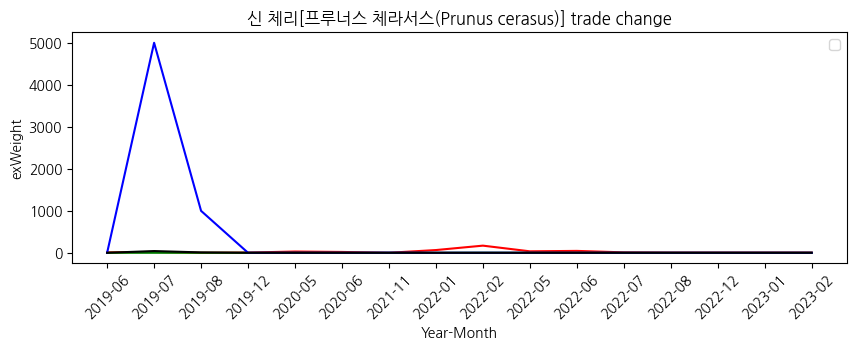

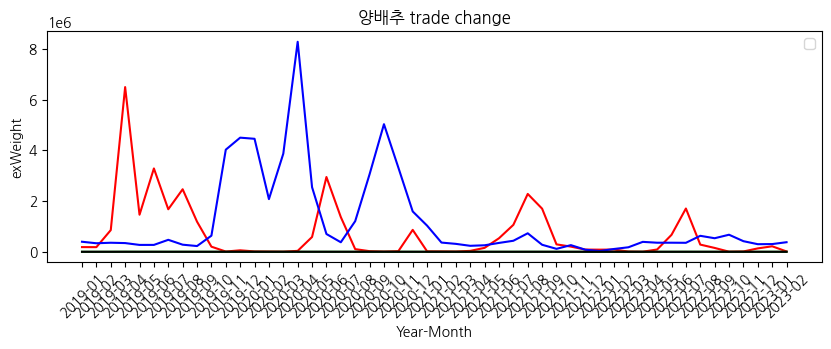

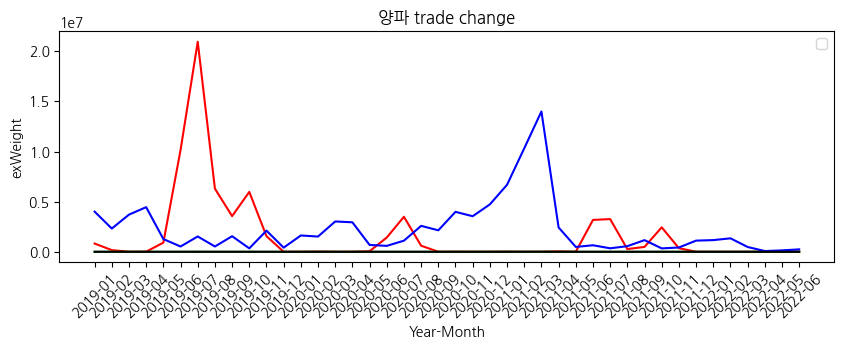

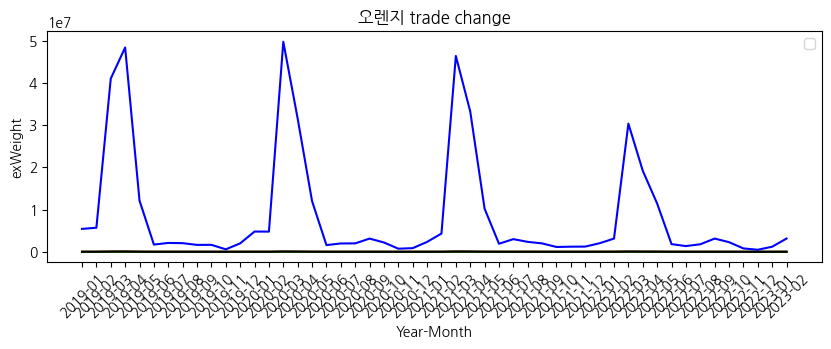

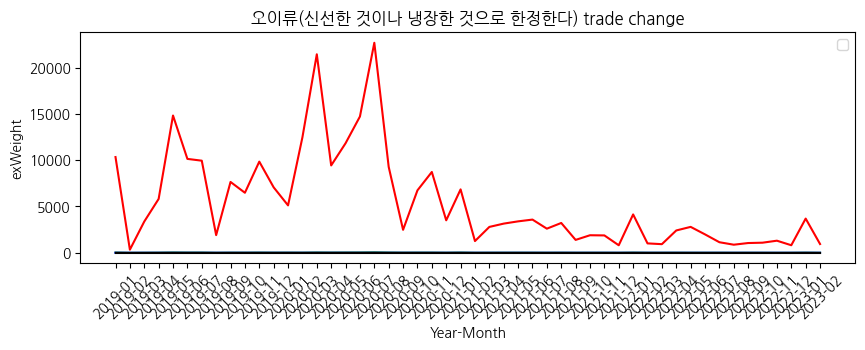

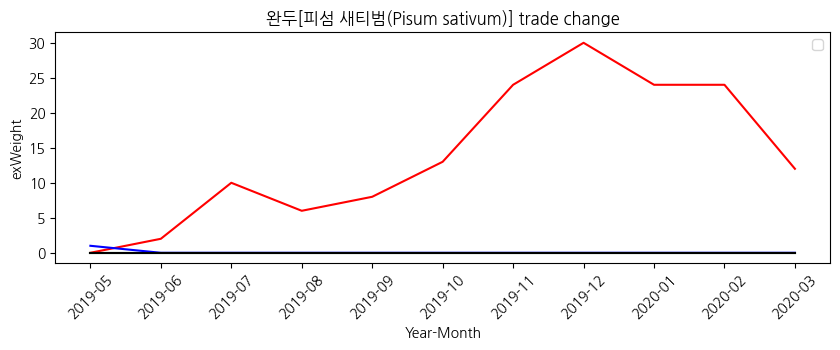

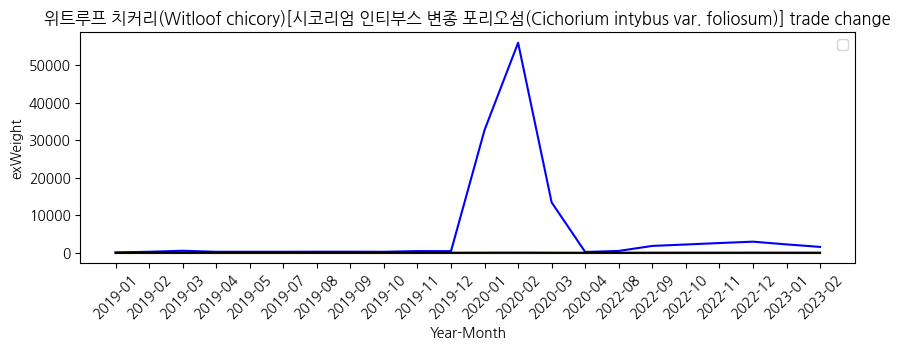

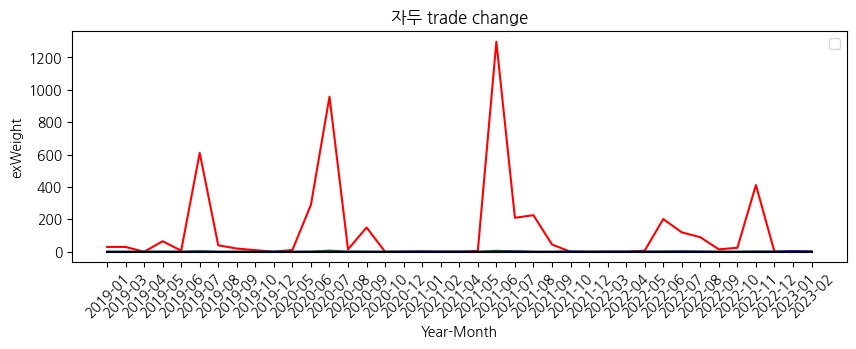

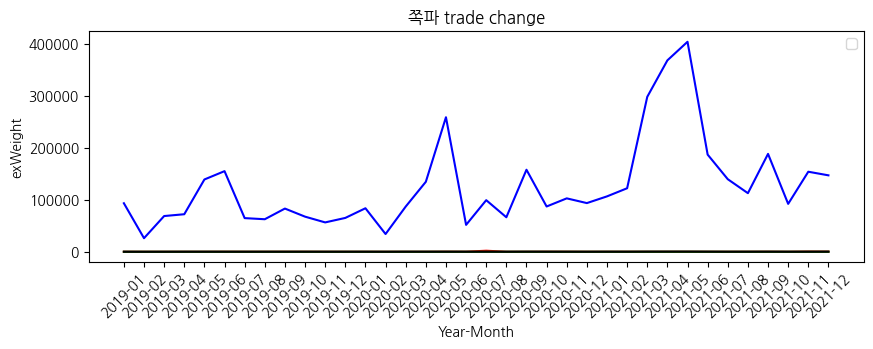

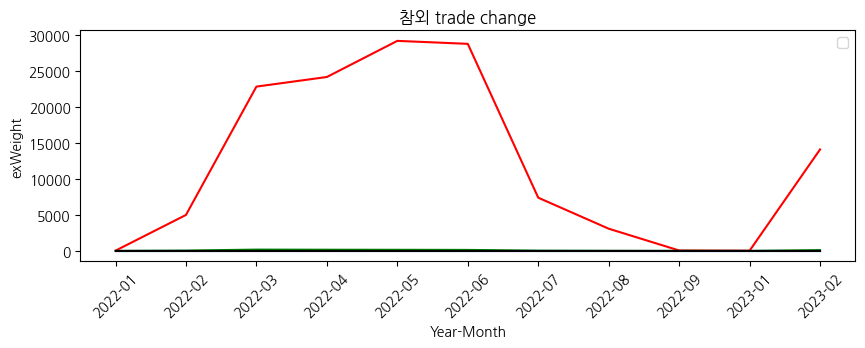

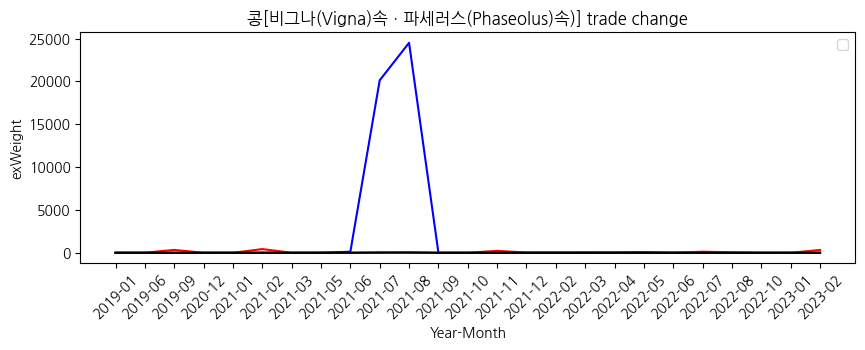

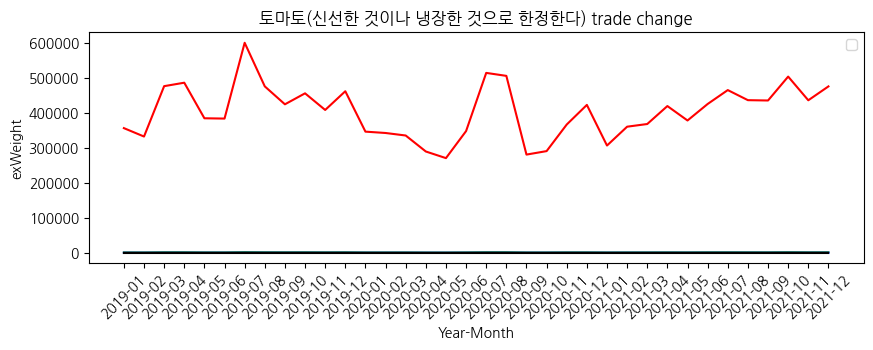

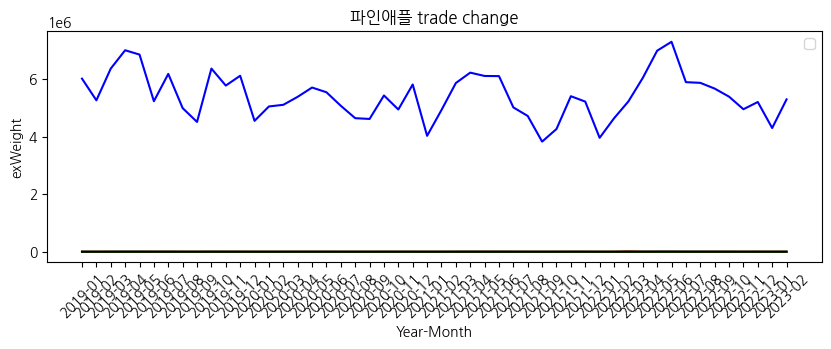

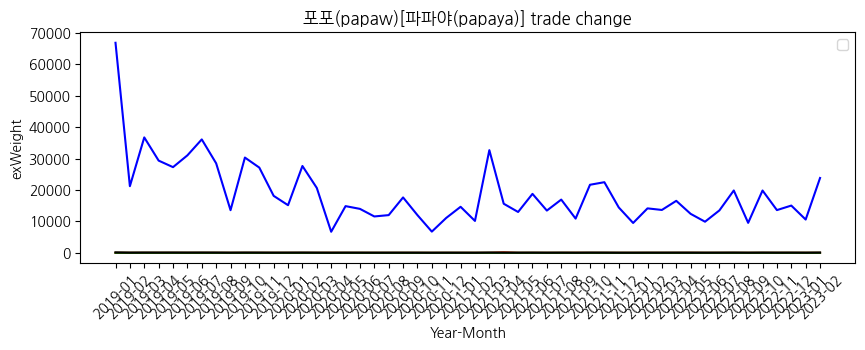

In [69]:
for item in trade_df.item.unique() :
    filtered_df = trade_df[trade_df.item == item]

    plt.figure(figsize = (10,3))
    plt.plot(filtered_df.period, filtered_df.exWeight, color = 'r')
    plt.plot(filtered_df.period, filtered_df.exValue, color = 'g')

    plt.plot(filtered_df.period, filtered_df.imWeight, color = 'b')
    plt.plot(filtered_df.period, filtered_df.imValue, color = 'k')

    plt.title(f'{item} trade change')

    # Show legend and labels
    plt.legend()
    plt.xlabel('Year-Month')
    plt.ylabel('exWeight')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

    # Display the plot
    plt.show()

    # 수출 농산물 , 수입 농산물

In [129]:
train_df.groupby(['month_of_year', 'item'])[['price', 'supply']].sum().reset_index()

,month_of_year,item,price,supply
0,2019-01,BC,356586.0,695871.0
1,2019-01,CB,30931.0,3408100.0
2,2019-01,CR,112808.0,2370540.0
3,2019-01,RD,59354.0,13685460.0
4,2019-01,TG,460469.0,14704526.7
...,...,...,...,...
250,2023-03,BC,65156.0,61472.0
251,2023-03,CB,8502.0,774976.0
252,2023-03,CR,24364.0,410376.0
253,2023-03,RD,10699.0,1519520.0


In [130]:
pattern = '자두|수박|사과|복숭아|배|감귤'

mask = trade_df['item'].astype(str).str.contains(pattern, regex=True)
fruit_df = trade_df[mask]

In [131]:
# international['month'] = pd.to_datetime(international['month'], format='%Y-%m')
# international['month'] = (international['month'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')

In [132]:
international['year'] = international['period'].apply(lambda x : int(x[0:4]))
international['month'] = international['period'].apply(lambda x : int(x[5:7]))
international.drop(columns = 'period', inplace=True)
international

,item,exWeight,exValue,imWeight,imValue,tradeBalance,year,month
0,토마토(신선한 것이나 냉장한 것으로 한정한다),356571,990,0,0,990,2019,1
1,양파,821330,222,4003206,1118,-896,2019,1
2,쪽파,60,1,93405,128,-127,2019,1
3,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562,2019,1
4,방울다다기 양배추,0,0,7580,38,-38,2019,1
...,...,...,...,...,...,...,...,...
1269,포포(papaw)[파파야(papaya)],0,0,23830,71,-71,2023,2
1270,사과,135165,351,0,0,351,2023,2
1271,배,2206012,5411,1,0,5411,2023,2
1272,신 체리[프루너스 체라서스(Prunus cerasus)],5,0,0,0,0,2023,2


In [133]:
selected_items = international[international['item'].str.contains('감귤|브로콜리|무|당근|양배추')].copy()

selected_items['item'] = selected_items['item'].replace({
    '감귤': 'TG',
    '브로콜리': 'BC',
    '무': 'RD',
    '당근': 'CR',
    '양배추': 'CB'
}, regex = True)

selected_items['item'] = selected_items['item'].str.replace('.*감귤.*', 'TG')
selected_items['item'] = selected_items['item'].str.replace('.*브로콜리.*', 'BC')
selected_items['item'] = selected_items['item'].str.replace('.*무.*', 'RD')
selected_items['item'] = selected_items['item'].str.replace('.*당근.*', 'CR')
selected_items['item'] = selected_items['item'].str.replace('.*양배추.*', 'CB')

selected_items

,item,exWeight,exValue,imWeight,imValue,tradeBalance,year,month
3,꽃CB와 BC(broccoli),160,1,638913,563,-562,2019,1
4,방울다다기 CB,0,0,7580,38,-38,2019,1
5,CB,184650,94,395802,90,4,2019,1
8,CR,23150,22,7466150,2955,-2934,2019,1
12,RD화과,2627,23,94529,464,-441,2019,1
...,...,...,...,...,...,...,...,...
1250,CB,13188,13,377456,104,-91,2023,2
1253,CR,22510,20,9260020,3758,-3737,2023,2
1254,순RD,4000,4,2,0,4,2023,2
1258,RD화과,1319,14,104566,454,-440,2023,2


In [134]:
selected_items.item.value_counts()

꽃CB와 BC(broccoli)    50
방울다다기 CB             50
CB                   50
CR                   50
RD화과                 50
TG                   50
순RD                   6
Name: item, dtype: int64

In [135]:
train_df = train_df.merge(selected_items, on=['year', 'month', 'item'], how='left')
test_df = test_df.merge(selected_items, on=['year', 'month', 'item'], how='left')

# price항목은 있고 없고 동일함
train_df['exPrice'] = train_df['exValue'] / train_df['exWeight']
train_df['imPrice'] = train_df['imValue'] / train_df['imWeight']

test_df['exPrice'] = test_df['exValue'] / test_df['exWeight']
test_df['imPrice'] = test_df['imValue'] / test_df['imWeight']


train_df

,ID,timestamp,item,corporation,location,supply,price,year,month,week,...,month_price_max,month_supply_mean,month_supply_max,exWeight,exValue,imWeight,imValue,tradeBalance,exPrice,imPrice
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,...,4031.0,47433.957097,268073.4,58368.0,172.0,0.0,0.0,172.0,0.002947,NaN
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,1,...,4031.0,47433.957097,268073.4,58368.0,172.0,0.0,0.0,172.0,0.002947,NaN
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,1,...,4031.0,47433.957097,268073.4,58368.0,172.0,0.0,0.0,172.0,0.002947,NaN
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,1,...,4031.0,47433.957097,268073.4,58368.0,172.0,0.0,0.0,172.0,0.002947,NaN
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,1,...,4031.0,47433.957097,268073.4,58368.0,172.0,0.0,0.0,172.0,0.002947,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0,2023,2,9,...,1900.0,55495.388393,657220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0,2023,2,9,...,1900.0,55495.388393,657220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0,2023,3,9,...,709.0,63313.333333,477220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0,2023,3,9,...,709.0,63313.333333,477220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

train_df.isnull().sum().sum() , test_df.isnull().sum().sum()

(0, 0)

## 기타 피쳐추가

In [137]:
# 품목별 평균 가격
item_mean_price = train_df.groupby('item')['price'].mean().reset_index()
item_mean_price.columns = ['item', 'item_mean_price']

train_df = train_df.merge(item_mean_price, on='item', how='left')
test_df = test_df.merge(item_mean_price, on='item', how='left')

# 법인별 평균 가격
corp_mean_price = train_df.groupby('corporation')['price'].mean().reset_index()
corp_mean_price.columns = ['corporation', 'corp_mean_price']

train_df = train_df.merge(corp_mean_price, on='corporation', how='left')
test_df = test_df.merge(corp_mean_price, on='corporation', how='left')

# 지역별 평균 가격
location_mean_price = train_df.groupby('location')['price'].mean().reset_index()
location_mean_price.columns = ['location', 'location_mean_price']

train_df = train_df.merge(location_mean_price, on='location', how='left')
test_df = test_df.merge(location_mean_price, on='location', how='left')

In [138]:
train_df

,ID,timestamp,item,corporation,location,supply,price,year,month,week,...,exWeight,exValue,imWeight,imValue,tradeBalance,exPrice,imPrice,item_mean_price,corp_mean_price,location_mean_price
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,...,58368.0,172.0,0.0,0.0,172.0,0.002947,0.0,3177.442022,1141.704458,1062.35148
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,1,...,58368.0,172.0,0.0,0.0,172.0,0.002947,0.0,3177.442022,1141.704458,1062.35148
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,1,...,58368.0,172.0,0.0,0.0,172.0,0.002947,0.0,3177.442022,1141.704458,1062.35148
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,1,...,58368.0,172.0,0.0,0.0,172.0,0.002947,0.0,3177.442022,1141.704458,1062.35148
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,1,...,58368.0,172.0,0.0,0.0,172.0,0.002947,0.0,3177.442022,1141.704458,1062.35148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0,2023,2,9,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,187.073539,259.121799,1062.35148
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0,2023,2,9,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,187.073539,259.121799,1062.35148
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0,2023,3,9,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,187.073539,259.121799,1062.35148
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0,2023,3,9,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,187.073539,259.121799,1062.35148


In [ ]:
# lag_period = 30

# train_df['lag_price'] = train_df['supply'].shift(lag_period)
# test_df['lag_price'] = test_df['supply'].shift(lag_period)

# Encoding

## 라벨

In [139]:
obj_cols = ['item', 'corporation', 'location']

for col in obj_cols:
    enc = LabelEncoder()
    train_df[col]=enc.fit_transform(train_df[col])
    test_df[col]=enc.transform(test_df[col])

train_df.head()

,ID,timestamp,item,corporation,location,supply,price,year,month,week,...,exWeight,exValue,imWeight,imValue,tradeBalance,exPrice,imPrice,item_mean_price,corp_mean_price,location_mean_price
0,TG_A_J_20190101,2019-01-01,4,0,0,0.0,0.0,2019,1,1,...,58368.0,172.0,0.0,0.0,172.0,0.002947,0.0,3177.442022,1141.704458,1062.35148
1,TG_A_J_20190102,2019-01-02,4,0,0,0.0,0.0,2019,1,1,...,58368.0,172.0,0.0,0.0,172.0,0.002947,0.0,3177.442022,1141.704458,1062.35148
2,TG_A_J_20190103,2019-01-03,4,0,0,60601.0,1728.0,2019,1,1,...,58368.0,172.0,0.0,0.0,172.0,0.002947,0.0,3177.442022,1141.704458,1062.35148
3,TG_A_J_20190104,2019-01-04,4,0,0,25000.0,1408.0,2019,1,1,...,58368.0,172.0,0.0,0.0,172.0,0.002947,0.0,3177.442022,1141.704458,1062.35148
4,TG_A_J_20190105,2019-01-05,4,0,0,32352.0,1250.0,2019,1,1,...,58368.0,172.0,0.0,0.0,172.0,0.002947,0.0,3177.442022,1141.704458,1062.35148


In [140]:
train_df['week'] = train_df['week'].astype(float)
train_df['cos_week_of_year'] = train_df['cos_week_of_year'].astype(float)
train_df['sin_week_of_year'] = train_df['sin_week_of_year'].astype(float)

test_df['week'] = test_df['week'].astype(float)
test_df['cos_week_of_year'] = test_df['cos_week_of_year'].astype(float)
test_df['sin_week_of_year'] = test_df['sin_week_of_year'].astype(float)

# AutoGluon

In [141]:
target = train_df['price']
target

0           0.0
1           0.0
2        1728.0
3        1408.0
4        1250.0
          ...  
59392     468.0
59393     531.0
59394     574.0
59395     523.0
59396     529.0
Name: price, Length: 59397, dtype: float64

In [142]:
train_df['item_id'] = train_df.ID.str[0:6]
train_df

,ID,timestamp,item,corporation,location,supply,price,year,month,week,...,exValue,imWeight,imValue,tradeBalance,exPrice,imPrice,item_mean_price,corp_mean_price,location_mean_price,item_id
0,TG_A_J_20190101,2019-01-01,4,0,0,0.0,0.0,2019,1,1.0,...,172.0,0.0,0.0,172.0,0.002947,0.0,3177.442022,1141.704458,1062.35148,TG_A_J
1,TG_A_J_20190102,2019-01-02,4,0,0,0.0,0.0,2019,1,1.0,...,172.0,0.0,0.0,172.0,0.002947,0.0,3177.442022,1141.704458,1062.35148,TG_A_J
2,TG_A_J_20190103,2019-01-03,4,0,0,60601.0,1728.0,2019,1,1.0,...,172.0,0.0,0.0,172.0,0.002947,0.0,3177.442022,1141.704458,1062.35148,TG_A_J
3,TG_A_J_20190104,2019-01-04,4,0,0,25000.0,1408.0,2019,1,1.0,...,172.0,0.0,0.0,172.0,0.002947,0.0,3177.442022,1141.704458,1062.35148,TG_A_J
4,TG_A_J_20190105,2019-01-05,4,0,0,32352.0,1250.0,2019,1,1.0,...,172.0,0.0,0.0,172.0,0.002947,0.0,3177.442022,1141.704458,1062.35148,TG_A_J
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,3,5,0,452440.0,468.0,2023,2,9.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,187.073539,259.121799,1062.35148,RD_F_J
59393,RD_F_J_20230228,2023-02-28,3,5,0,421980.0,531.0,2023,2,9.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,187.073539,259.121799,1062.35148,RD_F_J
59394,RD_F_J_20230301,2023-03-01,3,5,0,382980.0,574.0,2023,3,9.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,187.073539,259.121799,1062.35148,RD_F_J
59395,RD_F_J_20230302,2023-03-02,3,5,0,477220.0,523.0,2023,3,9.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,187.073539,259.121799,1062.35148,RD_F_J


In [143]:
test_df['item_id'] = test_df.ID.str[0:6]
test_df

,ID,timestamp,item,corporation,location,year,month,week,day,day_of_week,...,exValue,imWeight,imValue,tradeBalance,exPrice,imPrice,item_mean_price,corp_mean_price,location_mean_price,item_id
0,TG_A_J_20230304,2023-03-04,4,0,0,2023,3,9.0,4,5,...,0.0,0.0,0.0,0.0,0.0,0.0,3177.442022,1141.704458,1062.35148,TG_A_J
1,TG_A_J_20230305,2023-03-05,4,0,0,2023,3,9.0,5,6,...,0.0,0.0,0.0,0.0,0.0,0.0,3177.442022,1141.704458,1062.35148,TG_A_J
2,TG_A_J_20230306,2023-03-06,4,0,0,2023,3,10.0,6,0,...,0.0,0.0,0.0,0.0,0.0,0.0,3177.442022,1141.704458,1062.35148,TG_A_J
3,TG_A_J_20230307,2023-03-07,4,0,0,2023,3,10.0,7,1,...,0.0,0.0,0.0,0.0,0.0,0.0,3177.442022,1141.704458,1062.35148,TG_A_J
4,TG_A_J_20230308,2023-03-08,4,0,0,2023,3,10.0,8,2,...,0.0,0.0,0.0,0.0,0.0,0.0,3177.442022,1141.704458,1062.35148,TG_A_J
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,RD_F_J_20230327,2023-03-27,3,5,0,2023,3,13.0,27,0,...,0.0,0.0,0.0,0.0,0.0,0.0,187.073539,259.121799,1062.35148,RD_F_J
1088,RD_F_J_20230328,2023-03-28,3,5,0,2023,3,13.0,28,1,...,0.0,0.0,0.0,0.0,0.0,0.0,187.073539,259.121799,1062.35148,RD_F_J
1089,RD_F_J_20230329,2023-03-29,3,5,0,2023,3,13.0,29,2,...,0.0,0.0,0.0,0.0,0.0,0.0,187.073539,259.121799,1062.35148,RD_F_J
1090,RD_F_J_20230330,2023-03-30,3,5,0,2023,3,13.0,30,3,...,0.0,0.0,0.0,0.0,0.0,0.0,187.073539,259.121799,1062.35148,RD_F_J


In [92]:
# train_dropcols = ['ID', 'supply', 'month_of_year']
# test_dropcols = ['ID', 'month_of_year']

In [103]:
# train_df = train_df.drop(columns = train_dropcols)
# test_df = test_df.drop(columns = test_dropcols)

In [144]:
mask = train_df['ID'].str.startswith('TG')
train_df_tg = train_df[mask]
mask = test_df['ID'].str.startswith('TG')
test_df_tg = test_df[mask]

mask = train_df['ID'].str.startswith('BC')
train_df_bc = train_df[mask]
mask = test_df['ID'].str.startswith('BC')
test_df_bc = test_df[mask]

mask = train_df['ID'].str.startswith('RD')
train_df_rd = train_df[mask]
mask = test_df['ID'].str.startswith('RD')
test_df_rd = test_df[mask]



train_df_tg

,ID,timestamp,item,corporation,location,supply,price,year,month,week,...,exValue,imWeight,imValue,tradeBalance,exPrice,imPrice,item_mean_price,corp_mean_price,location_mean_price,item_id
0,TG_A_J_20190101,2019-01-01,4,0,0,0.0,0.0,2019,1,1.0,...,172.0,0.0,0.0,172.0,0.002947,0.00000,3177.442022,1141.704458,1062.35148,TG_A_J
1,TG_A_J_20190102,2019-01-02,4,0,0,0.0,0.0,2019,1,1.0,...,172.0,0.0,0.0,172.0,0.002947,0.00000,3177.442022,1141.704458,1062.35148,TG_A_J
2,TG_A_J_20190103,2019-01-03,4,0,0,60601.0,1728.0,2019,1,1.0,...,172.0,0.0,0.0,172.0,0.002947,0.00000,3177.442022,1141.704458,1062.35148,TG_A_J
3,TG_A_J_20190104,2019-01-04,4,0,0,25000.0,1408.0,2019,1,1.0,...,172.0,0.0,0.0,172.0,0.002947,0.00000,3177.442022,1141.704458,1062.35148,TG_A_J
4,TG_A_J_20190105,2019-01-05,4,0,0,32352.0,1250.0,2019,1,1.0,...,172.0,0.0,0.0,172.0,0.002947,0.00000,3177.442022,1141.704458,1062.35148,TG_A_J
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15225,TG_E_S_20230227,2023-02-27,4,4,1,24204.0,3418.0,2023,2,9.0,...,34.0,27765.0,98.0,-64.0,0.004931,0.00353,3177.442022,956.251404,1231.34139,TG_E_S
15226,TG_E_S_20230228,2023-02-28,4,4,1,13587.0,3141.0,2023,2,9.0,...,34.0,27765.0,98.0,-64.0,0.004931,0.00353,3177.442022,956.251404,1231.34139,TG_E_S
15227,TG_E_S_20230301,2023-03-01,4,4,1,16187.0,4235.0,2023,3,9.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,3177.442022,956.251404,1231.34139,TG_E_S
15228,TG_E_S_20230302,2023-03-02,4,4,1,17830.0,3960.0,2023,3,9.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,3177.442022,956.251404,1231.34139,TG_E_S


In [145]:
train_dropcols = ['ID', 'supply', 'month_of_year']
test_dropcols = ['ID', 'month_of_year']

train_df_tg = train_df_tg.drop(columns = train_dropcols)
test_df_tg = test_df_tg.drop(columns = test_dropcols)

In [146]:
# from autogluon.tabular import TabularPredictor
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
data = TimeSeriesDataFrame(train_df_tg)

In [147]:
predictor = TimeSeriesPredictor(
    prediction_length=28,
    target="price",
    eval_metric="RMSE"
)
# seed 고정
predictor.fit(data, random_seed=SEED)

No path specified. Models will be saved in: "AutogluonModels/ag-20231113_053303/"
================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'RMSE',
 'excluded_model_types': None,
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'default',
 'num_val_windows': 1,
 'prediction_length': 28,
 'random_seed': 42,
 'target': 'price',
 'time_limit': None,
 'verbosity': 2}
Provided training data set with 15230 rows, 10 items (item = single time series). Average time series length is 1523.0. Data frequency is 'D'.
AutoGluon will save models to AutogluonModels/ag-20231113_053303/
AutoGluon will gauge predictive performance using evaluation metric: 'RMSE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.

Provided dataset contains following columns:
	target:           'price'
	past covariates:  ['it


KeyboardInterrupt



# 예측

In [ ]:
# 모델 재학습
predictor.refit_full()

In [ ]:
pred = predictor.predict(data, random_seed=SEED)
pred

In [ ]:
pred = pred.reset_index()['mean']
pred

In [ ]:
# 마이너스 값 0으로 치환
pred[pred < 0] = 0

# 제출

In [ ]:
submission

In [ ]:
submission['answer'] = pred
submission

In [ ]:
submission.to_csv(f"{DATA_PATH}submission_23_1113.csv", index=False)
submission.to_csv("submission_23_1113.csv", index=False)